In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import sqlite3
import json
import seaborn as sns
import numpy as np
import sklearn

In [ ]:
def load_db_labels(db_name):
  db_path = f'/content/drive/MyDrive/capi/data/public/{db_name}.db'
  query = 'SELECT \
            Session.time, \
            Session.label, \
            SessionMeta.* \
          FROM \
            Session \
            JOIN SessionMeta ON SessionMeta.session = CAST(Session.session AS INT)'
  with sqlite3.connect(db_path) as connection:
    return pd.read_sql_query(query, connection)

In [ ]:
db = load_db_labels('ron')

In [ ]:
db.head()

,time,label,session,dominate_window,dominate_task,window_switches,task_switches,window_count,task_count
0,1.618152e+09,"{'categorical': 'surprise', 'VAD': {'valance':...",0,explorer.exe,interactive,0.0,0.0,1.0,1.0
1,1.618152e+09,"{'categorical': 'surprise', 'VAD': {'valance':...",1,explorer.exe,interactive,0.0,0.0,1.0,1.0
2,1.618152e+09,"{'categorical': 'surprise', 'VAD': {'valance':...",2,explorer.exe,interactive,0.0,0.0,1.0,1.0
3,1.618152e+09,"{'categorical': 'surprise', 'VAD': {'valance':...",3,explorer.exe,interactive,0.0,0.0,1.0,1.0
4,1.618152e+09,"{'categorical': 'surprise', 'VAD': {'valance':...",4,explorer.exe,interactive,0.0,0.0,1.0,1.0


In [ ]:
db.describe()

,time,session,window_switches,task_switches,window_count,task_count
count,2.161000e+03,2161.000000,2161.000000,2161.000000,2161.000000,2161.000000
mean,1.618154e+09,1082.903748,0.019898,0.010643,1.019898,1.010643
std,1.094288e+03,625.522804,0.146161,0.102639,0.146161,0.102639
min,1.618152e+09,0.000000,0.000000,0.000000,1.000000,1.000000
25%,1.618154e+09,542.000000,0.000000,0.000000,1.000000,1.000000
50%,1.618154e+09,1082.000000,0.000000,0.000000,1.000000,1.000000
75%,1.618155e+09,1625.000000,0.000000,0.000000,1.000000,1.000000
max,1.618156e+09,2165.000000,2.000000,1.000000,3.000000,2.000000


In [ ]:
def process_db(db):
  valance_list = []
  arousal_list = []
  dominance_list = []

  categorical_list = []

  for index, row in db.iterrows():
      
      updated_row = row['label'].replace('\'','\"')
      
      label = json.loads(updated_row)
      
      if label == -1:
        label = previous_label
      
      if "label" in label:
        db = db.drop([index])
        continue
      
      if label["categorical"] == "none":
        label["categorical"] = previous_label["categorical"]
      categorical_list.append(label["categorical"])
      
      if label["VAD"]["valance"] == "none":
        label["VAD"]["valance"] = previous_label["VAD"]["valance"]
      valance_list.append(label["VAD"]["valance"])
      
      if label["VAD"]["arousal"] == "none":
        label["VAD"]["arousal"] = previous_label["VAD"]["arousal"]
      arousal_list.append(label["VAD"]["arousal"])
      
      if label["VAD"]["dominance"] == "none":
        label["VAD"]["dominance"] = previous_label["VAD"]["dominance"]
      dominance_list.append(label["VAD"]["dominance"])
      
      previous_label = label

  db["valance"] = valance_list
  db["arousal"] = arousal_list
  db["dominance"] = dominance_list
  db["categorical"] = categorical_list
  db = db.drop(columns=["label"])
  return db

In [ ]:
db = process_db(db)
db.head() 

,time,session,dominate_window,dominate_task,window_switches,task_switches,window_count,task_count,valance,arousal,dominance,categorical
0,1.618152e+09,0,explorer.exe,interactive,0.0,0.0,1.0,1.0,6,4,2,surprise
1,1.618152e+09,1,explorer.exe,interactive,0.0,0.0,1.0,1.0,6,4,2,surprise
2,1.618152e+09,2,explorer.exe,interactive,0.0,0.0,1.0,1.0,6,4,2,surprise
3,1.618152e+09,3,explorer.exe,interactive,0.0,0.0,1.0,1.0,6,4,2,surprise
4,1.618152e+09,4,explorer.exe,interactive,0.0,0.0,1.0,1.0,6,4,2,surprise


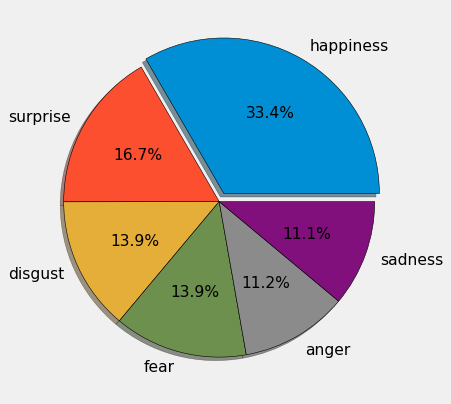

In [ ]:
plt.style.use("fivethirtyeight")
label_count = list(db["categorical"].value_counts())
label_kind = list(db["categorical"].value_counts().index)
explode = [0.06,0,0,0,0,0]
plt.figure(figsize=(8, 6), dpi=80)

plt.pie(x=label_count, labels=label_kind,wedgeprops={"edgecolor":"black"},textprops={'fontsize': 14},explode=explode,shadow=True,autopct="%1.1f%%")

plt.show()

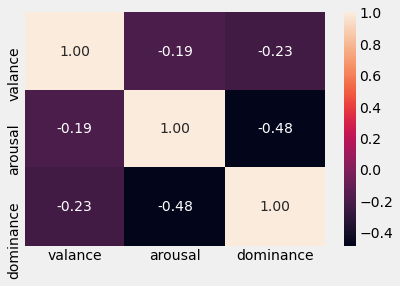

In [ ]:
db["positive"] = (db["valance"] >= 4).astype(int)
VAD_db = db[['valance', 'arousal', 'dominance','positive']]
corr = VAD_db.drop(columns=["positive"]).corr()
sns.heatmap(corr,fmt='.2f',annot=True)
VAD_db = VAD_db[['valance', 'arousal', 'dominance']]

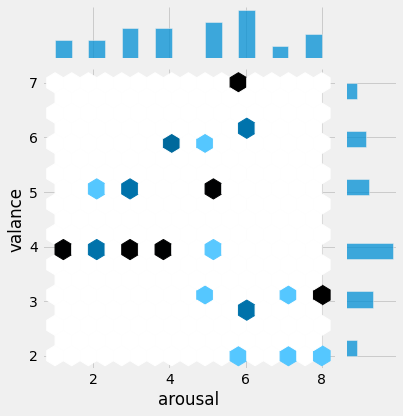

In [ ]:
sns.jointplot(x=VAD_db['arousal'],y=VAD_db['valance'],kind="hex")

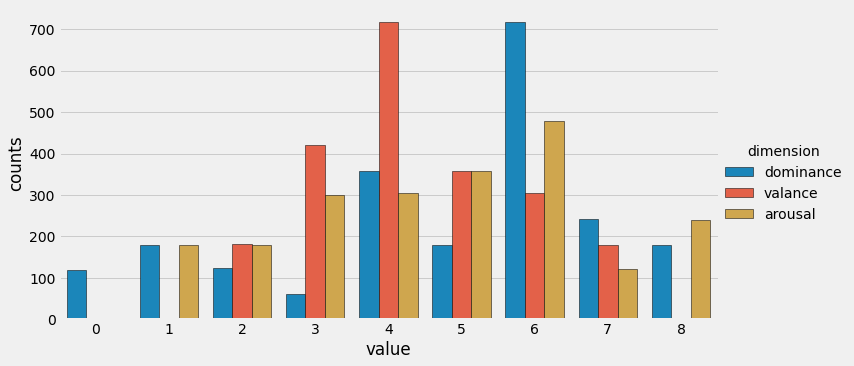

In [ ]:
melt_VAD_db = VAD_db.melt(value_vars=['arousal','valance','dominance'])
kinds = []
levels = []
for kind,level in melt_VAD_db.value_counts().index:
  kinds.append(kind)
  levels.append(level)
melt_VAD_db_no_dups = pd.DataFrame(columns=["dimension","value","counts"])
melt_VAD_db_no_dups['dimension'] = kinds
melt_VAD_db_no_dups['value'] = levels
melt_VAD_db_no_dups['counts'] = list(melt_VAD_db.value_counts())
sns.catplot(x="value",y="counts",hue="dimension",data=melt_VAD_db_no_dups,kind='bar',aspect=2,edgecolor="black")

[Text(0, 0.5, 'VAD value')]

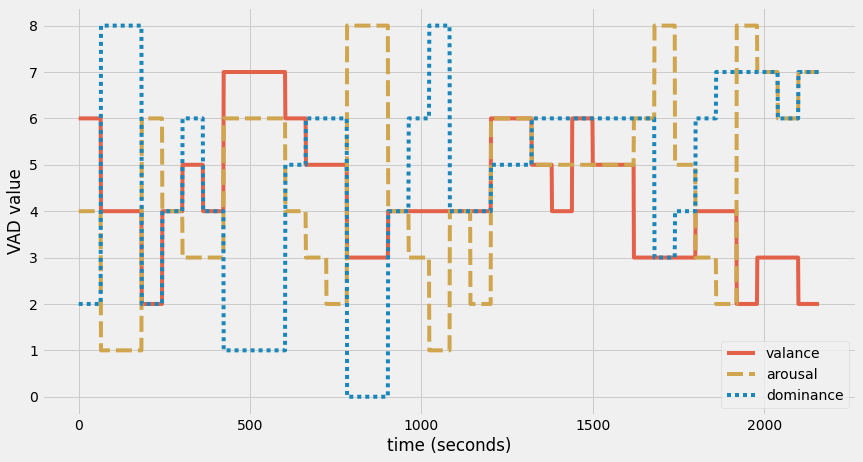

In [ ]:
fig, ax = plt.subplots(1,1,figsize=(13,7))
sns.lineplot(data=VAD_db, ax=ax,palette=["#E36149","#CFA64E","#1B86BA"])
ax.set(xlabel="time (seconds)")
ax.set(ylabel="VAD value")

In [ ]:
VAD_db.value_counts()

valance  arousal  dominance
7        6        1            180
5        5        6            179
4        4        4            179
         1        8            179
5        3        6            120
3        6        6            120
4        3        6            120
3        8        0            120
6        6        5            119
         4        2             65
2        7        7             61
3        8        3             60
2        8        7             60
3        5        4             60
         7        7             60
4        3        4             60
         2        4             60
                  7             60
5        2        6             60
6        4        5             60
         5        6             60
2        6        2             60
4        5        6             59
dtype: int64

In [ ]:
import plotly.express as px

px.scatter_3d(db, x='valance', y='arousal', z='dominance', color='categorical', symbol="positive")

In [ ]:
from sklearn.manifold import TSNE
VAD_2D = TSNE(n_components=2).fit_transform(VAD_db)
VAD_1D = TSNE(n_components=1).fit_transform(VAD_db)

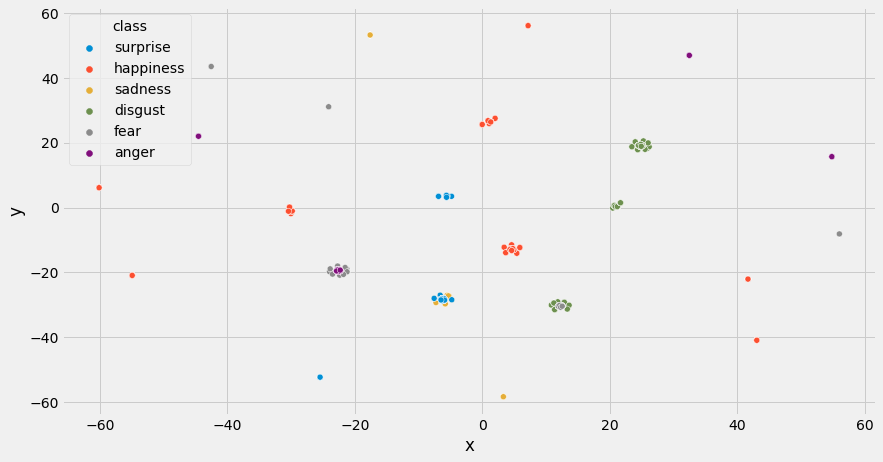

In [ ]:
xy_classes = pd.DataFrame(columns=["x","y","class"])
xy_classes["x"] = VAD_2D[:,0]
xy_classes["y"] = VAD_2D[:,1]
xy_classes["class"] = db["categorical"]
fig, ax = plt.subplots(1,1,figsize=(13,7))
sns.scatterplot(x="x",y="y",hue="class",data=xy_classes, ax=ax)

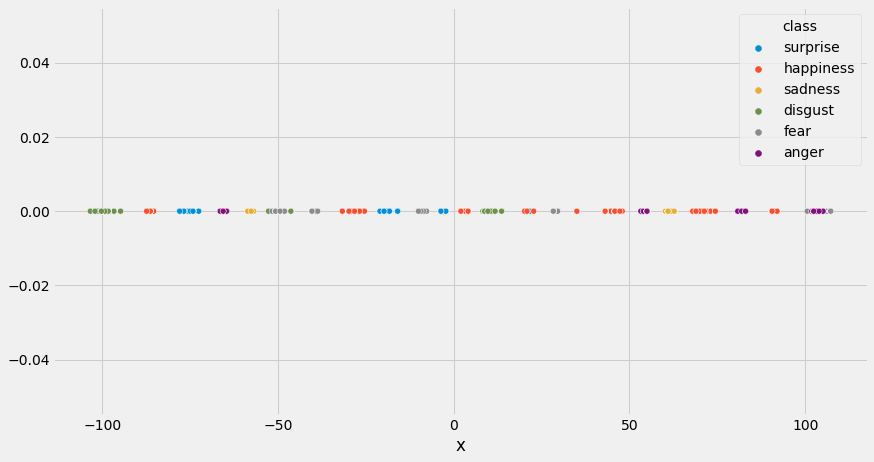

In [ ]:
xy_classes = pd.DataFrame(columns=["x","class"])
xy_classes["x"] = VAD_1D[:,0]
xy_classes["class"] = db["categorical"]
fig, ax = plt.subplots(1,1,figsize=(13,7))
sns.scatterplot(x="x",y=np.zeros(len(VAD_1D)),hue="class",data=xy_classes, ax=ax)

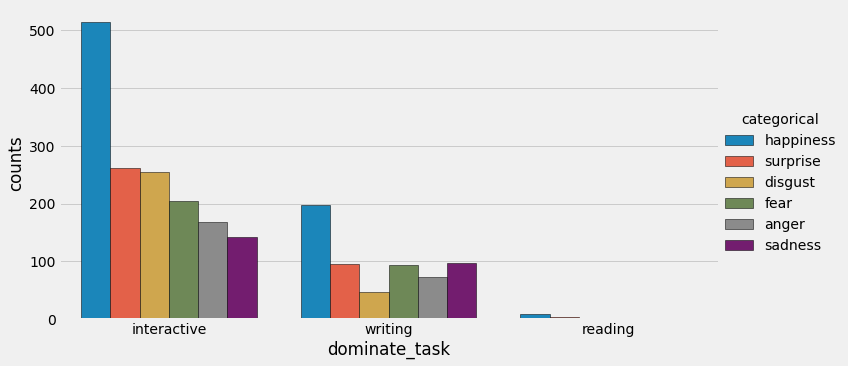

In [ ]:
kinds = []
labels = []

task_category_counts = db[['dominate_task','categorical']].value_counts()

for kind,label in task_category_counts.index:
  kinds.append(kind)
  labels.append(label)

task_category = pd.DataFrame(columns=["dominate_task","categorical","counts"])
task_category['dominate_task'] = kinds
task_category['categorical'] = labels
task_category['counts'] = list(task_category_counts)
sns.catplot(x="dominate_task",y="counts",hue="categorical",data=task_category,kind='bar',aspect=2,edgecolor="black")

In [ ]:
dbs_to_load = ["amit_dabash-no_images","liraz","niv","ron","shira-no_images","shiran","tal","tomer"]

dbs = []
for name in dbs_to_load:
  print(name)
  dbs.append(process_db(load_db_labels(name)))

amit_dabash-no_images
liraz
niv
ron
shira-no_images
shiran
tal
tomer


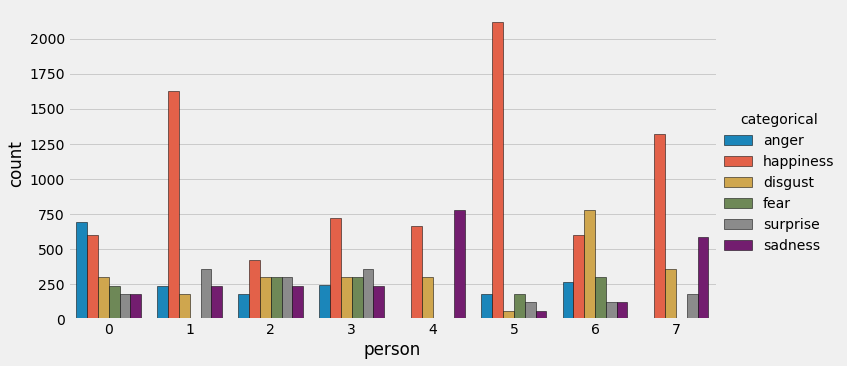

In [ ]:
categorical_count_each = pd.DataFrame(columns=["person","count","categorical"])

persons = []
counts = []
categoricals = []
for id, person_db in enumerate(dbs):
  counts += list(person_db["categorical"].value_counts())
  categorical_index = list(person_db["categorical"].value_counts().index)
  categoricals += categorical_index
  persons += [id] * len(categorical_index)
  # persons += [dbs_to_load[id]] * len(categorical_index)
categorical_count_each['person'] = persons
categorical_count_each['categorical'] = categoricals
categorical_count_each['count'] = counts

ax = sns.catplot(x="person",y="count",hue="categorical",data=categorical_count_each,kind='bar',aspect=2,edgecolor="black")
# ax.set_xticklabels(rotation=50)

[Text(0, 0.5, 'valance')]

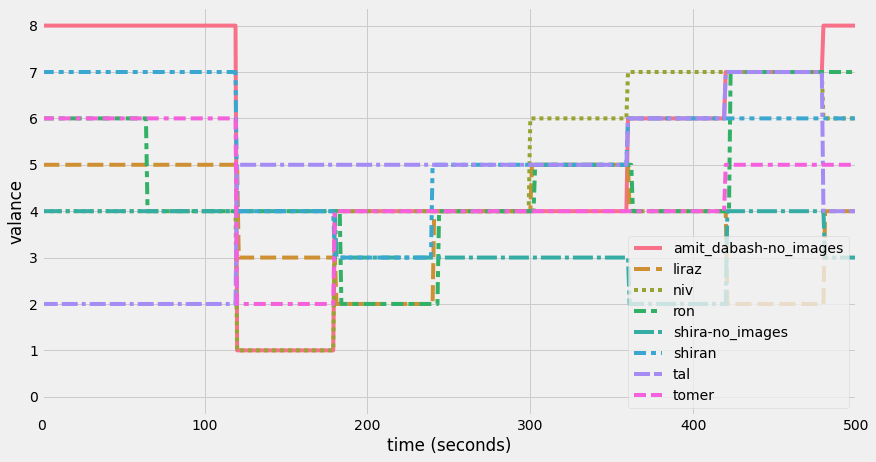

In [ ]:
persons_valance = pd.DataFrame()

for index, person_db in enumerate(dbs):
  persons_valance[dbs_to_load[index]] = person_db["valance"]

# corr = persons_valance.corr()
# sns.heatmap(corr,fmt='.2f',annot=True)

fig, ax = plt.subplots(1,1,figsize=(13,7))
ax = sns.lineplot(data=persons_valance, ax=ax)
ax.set(xlim=(0,500))
ax.set(xlabel="time (seconds)")
ax.set(ylabel="valance")

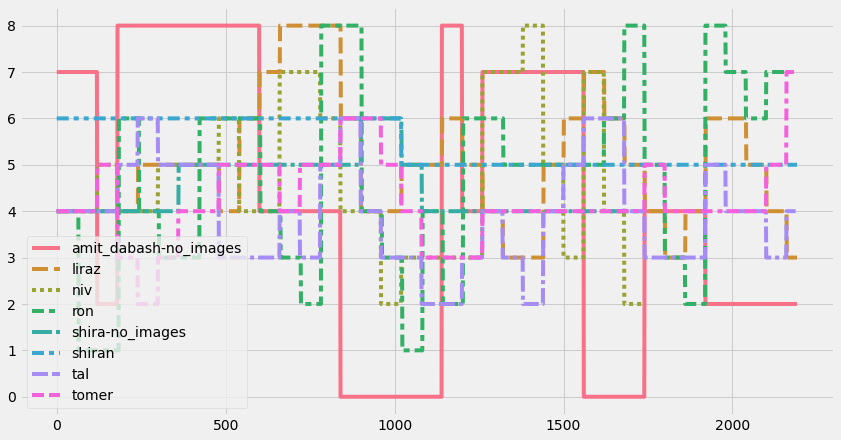

In [ ]:
persons_arousal = pd.DataFrame()

for index, person_db in enumerate(dbs):
  persons_arousal[dbs_to_load[index]] = person_db["arousal"]

# corr = persons_arousal.corr()
# sns.heatmap(corr,fmt='.2f',annot=True)

fig, ax = plt.subplots(1,1,figsize=(13,7))
ax = sns.lineplot(data=persons_arousal, ax=ax)
# ax.set(xlim=(500,1000))